# Imports and utility functions


In [1]:
from collections import Counter

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import fbeta_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader

from parser import load_saved_dataframe
from helper import *

# Dataset and model definitions


In [2]:
# Custom Dataset for your DataFrame
class TimeSeriesDataset(Dataset):
    def __init__(self, df):
        # Stack V1-V6 as channels: shape (num_samples, 6, series_length)
        self.X = torch.tensor(
            [
                [
                    row['timeseries_V1'],
                    row['timeseries_V2'],
                    row['timeseries_V3'],
                    row['timeseries_V4'],
                    row['timeseries_V5'],
                    row['timeseries_V6'],
                ]
                for _, row in df.iterrows()
            ],
            dtype=torch.float32
        )
        # Example: 0 for control, 1 for Amyloidosis
        self.y = torch.tensor(
            [0 if row['group'] == 'control' else 1 for _, row in df.iterrows()],
            dtype=torch.long
        )

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


# 1D CNN Model
class Strong1DCNN(nn.Module):
    def __init__(self, input_channels=6, num_classes=2):
        super().__init__()
        self.conv1 = nn.Conv1d(input_channels, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm1d(64)
        self.pool1 = nn.MaxPool1d(2)
        self.drop1 = nn.Dropout(0.2)

        self.conv2 = nn.Conv1d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm1d(128)
        self.pool2 = nn.MaxPool1d(2)
        self.drop2 = nn.Dropout(0.2)

        self.conv3 = nn.Conv1d(128, 256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm1d(256)
        self.pool3 = nn.MaxPool1d(2)
        self.drop3 = nn.Dropout(0.3)

        self.conv4 = nn.Conv1d(256, 512, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm1d(512)
        self.pool4 = nn.MaxPool1d(2)
        self.drop4 = nn.Dropout(0.3)

        self.global_avg_pool = nn.AdaptiveAvgPool1d(1)  # GlobalAveragePooling1D

        self.fc1 = nn.Linear(512, 256)
        self.bn_fc1 = nn.BatchNorm1d(256)
        self.drop_fc1 = nn.Dropout(0.5)

        self.fc2 = nn.Linear(256, 128)
        self.bn_fc2 = nn.BatchNorm1d(128)
        self.drop_fc2 = nn.Dropout(0.5)

        self.fc_out = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        x = self.pool1(x)
        x = self.drop1(x)

        x = self.conv2(x)
        x = F.relu(self.bn2(x))
        x = self.pool2(x)
        x = self.drop2(x)

        x = self.conv3(x)
        x = F.relu(self.bn3(x))
        x = self.pool3(x)
        x = self.drop3(x)

        x = self.conv4(x)
        x = F.relu(self.bn4(x))
        x = self.pool4(x)
        x = self.drop4(x)

        x = self.global_avg_pool(x)
        x = x.view(x.size(0), -1)

        x = self.fc1(x)
        x = F.relu(self.bn_fc1(x))
        x = self.drop_fc1(x)

        x = self.fc2(x)
        x = F.relu(self.bn_fc2(x))
        x = self.drop_fc2(x)

        x = self.fc_out(x)
        return x


def calculate_class_weights(y):
    """Calculate class weights for imbalanced dataset"""
    class_counts = Counter(y)
    total_samples = len(y)
    class_weights = {}

    for class_id, count in class_counts.items():
        class_weights[class_id] = total_samples / (len(class_counts) * count)

    return class_weights


def evaluate_model(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    all_predictions = []
    all_targets = []

    with torch.no_grad():
        for X_batch, y_batch in dataloader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            total_loss += loss.item()

            predictions = torch.argmax(outputs, dim=1)
            all_predictions.extend(predictions.cpu().numpy())
            all_targets.extend(y_batch.cpu().numpy())

    avg_loss = total_loss / len(dataloader)
    f2 = fbeta_score(all_targets, all_predictions, beta=2, average='weighted')
    precision = precision_score(all_targets, all_predictions, average='weighted')
    recall = recall_score(all_targets, all_predictions, average='weighted')

    return avg_loss, f2, precision, recall


def train_model_with_early_stopping(model, train_loader, val_loader,
                                    criterion, optimizer, scheduler,
                                    device, num_epochs=10,
                                    patience=10, min_delta=0.001):
    """Train model with early stopping based on validation F1 score"""

    # History tracking
    train_losses = []
    val_losses = []
    train_f2_scores = []
    val_f2_scores = []

    # Early stopping variables
    best_val_f2 = 0
    patience_counter = 0
    best_model_state = None

    print(f"Training for up to {num_epochs} epochs with early stopping...")
    print(f"Early stopping patience: {patience} epochs")
    print(f"Minimum improvement delta: {min_delta}")
    print("-" * 60)

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0
        train_preds = []
        train_targets = []

        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            train_preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
            train_targets.extend(y_batch.cpu().numpy())

        # Compute train F2 for this epoch
        train_f2 = fbeta_score(train_targets, train_preds, beta=2, average='weighted')
        train_f2_scores.append(train_f2)

        # Validation phase
        val_loss, val_f2, val_precision, val_recall = evaluate_model(
            model, val_loader, criterion, device
        )

        # Update learning rate
        scheduler.step(val_loss)

        # Track metrics
        avg_train_loss = train_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        val_losses.append(val_loss)
        val_f2_scores.append(val_f2)

        # Print progress
        if epoch % 5 == 0 or epoch < 10:
            print(f"Epoch {epoch + 1:3d}/{num_epochs} | "
                  f"Train Loss: {avg_train_loss:.4f} | "
                  f"Val Loss: {val_loss:.4f} | "
                  f"Val F2: {val_f2:.4f} | "
                  f"Val Precision: {val_precision:.4f} | "
                  f"Val Recall: {val_recall:.4f}")

        # Early stopping check
        if val_f2 > best_val_f2 + min_delta:
            best_val_f2 = val_f2
            patience_counter = 0
            best_model_state = model.state_dict().copy()
            print(f"New best validation F2: {val_f2:.4f} (epoch {epoch + 1})")
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"\nEarly stopping triggered after {epoch + 1} epochs")
            print(f"Best validation F2: {best_val_f2:.4f}")
            break

    # Load best model
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
        print("Loaded best model weights")

    return {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_f2_scores': train_f2_scores,
        'val_f2_scores': val_f2_scores,
        'best_val_f2': best_val_f2,
        'epochs_trained': epoch + 1
    }

# Data loading and splitting


In [3]:
df = load_saved_dataframe("timeseries_data.pkl")
series_length = len(df.iloc[0]['timeseries_V1'])

# Check class distribution
class_counts = df['group'].value_counts()
print("Class distribution:")
print(class_counts)
print(f"Imbalance ratio: {class_counts.max() / class_counts.min():.2f}")

# Create train-test-validation split
# First split: 80% train, 20% temp
train_df, temp_df = train_test_split(
    df,
    test_size=0.2,
    random_state=42,
    stratify=df['group']
)

# Second split: 50% of temp (10% of total) for validation, 50% for test
val_df, test_df = train_test_split(
    temp_df,
    test_size=0.5,
    random_state=42,
    stratify=temp_df['group']
)

print(f"\nDataset splits:")
print(f"Train: {len(train_df)} samples")
print(f"Validation: {len(val_df)} samples")
print(f"Test: {len(test_df)} samples")


DataFrame loaded successfully from timeseries_data.pkl
Class distribution:
group
control        981
Amyloidosis    373
Name: count, dtype: int64
Imbalance ratio: 2.63

Dataset splits:
Train: 1083 samples
Validation: 135 samples
Test: 136 samples


# Dataset and DataLoader creation


In [4]:
train_dataset = TimeSeriesDataset(train_df)
val_dataset = TimeSeriesDataset(val_df)
test_dataset = TimeSeriesDataset(test_df)

# Calculate class weights for imbalanced dataset
train_labels = [1 if row['group'] == 'control' else 0 for _, row in train_df.iterrows()]
class_weights = calculate_class_weights(train_labels)
print(f"\nClass weights: {class_weights}")

# Convert to tensor for loss function
weight_tensor = torch.tensor([class_weights[0], class_weights[1]], dtype=torch.float32)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)



Class weights: {0: 0.6898089171974522, 1: 1.8171140939597314}


# Model, optimizer, and training


In [5]:
# Initialize model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\nUsing device: {device}")

model = Strong1DCNN(input_channels=6, num_classes=2)
model.to(device)
weight_tensor = weight_tensor.to(device)

# Initialize optimizer and criterion with class weights
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss(weight=weight_tensor)

# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=5
)

# Train model with early stopping
history = train_model_with_early_stopping(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    device=device,
    num_epochs=50,
    patience=15,
    min_delta=0.001
)


Using device: cpu
Training for up to 50 epochs with early stopping...
Early stopping patience: 15 epochs
Minimum improvement delta: 0.001
------------------------------------------------------------
Epoch   1/50 | Train Loss: 0.2929 | Val Loss: 0.3439 | Val F2: 0.8984 | Val Precision: 0.9150 | Val Recall: 0.9037
New best validation F2: 0.8984 (epoch 1)
Epoch   2/50 | Train Loss: 0.2108 | Val Loss: 0.3918 | Val F2: 0.8647 | Val Precision: 0.8927 | Val Recall: 0.8741
Epoch   3/50 | Train Loss: 0.1749 | Val Loss: 0.2862 | Val F2: 0.9148 | Val Precision: 0.9267 | Val Recall: 0.9185
New best validation F2: 0.9148 (epoch 3)
Epoch   4/50 | Train Loss: 0.1951 | Val Loss: 0.3023 | Val F2: 0.9308 | Val Precision: 0.9389 | Val Recall: 0.9333
New best validation F2: 0.9308 (epoch 4)
Epoch   5/50 | Train Loss: 0.1813 | Val Loss: 0.3344 | Val F2: 0.9066 | Val Precision: 0.9208 | Val Recall: 0.9111
Epoch   6/50 | Train Loss: 0.1696 | Val Loss: 0.3217 | Val F2: 0.9308 | Val Precision: 0.9389 | Val Re

# Training history plots


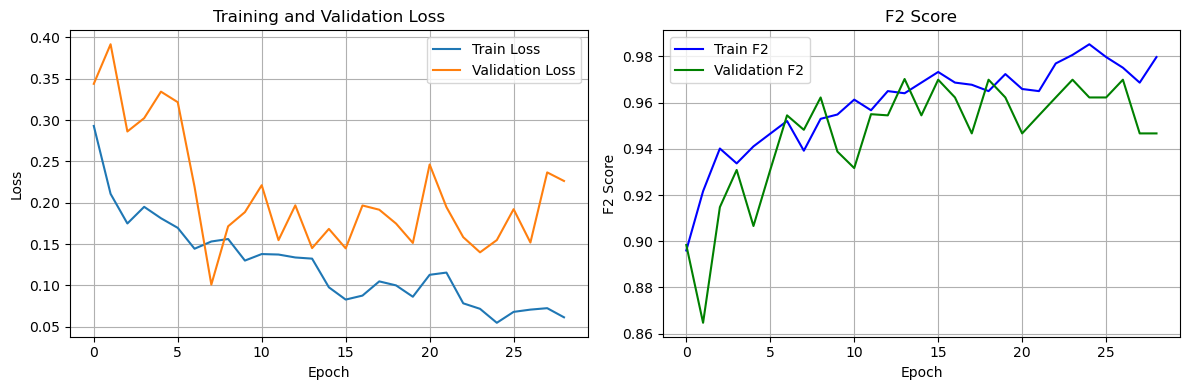

In [6]:
plot_training_history(history)

# Evaluation on validation and test sets


In [7]:
val_loss, val_f2, val_precision, val_recall = evaluate_model(
    model, val_loader, criterion, device
)
test_loss, test_f2, test_precision, test_recall = evaluate_model(
    model, test_loader, criterion, device
)

print(f"\nValidation Loss: {val_loss:.4f}")
print(f"Validation F2 Score: {val_f2:.4f}")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test F2 Score: {test_f2:.4f}")
print(f"Best Validation F2: {history['best_val_f2']:.4f}")
print(f"Total Epochs Trained: {history['epochs_trained']}")


Validation Loss: 0.2264
Validation F2 Score: 0.9467
Test Loss: 0.1733
Test F2 Score: 0.9329
Best Validation F2: 0.9702
Total Epochs Trained: 29


# Confusion matrix plots for validation and test sets

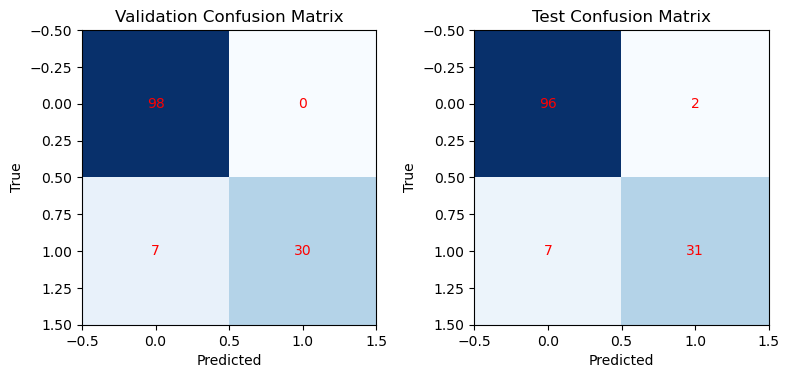

In [8]:
def get_predictions(model, dataloader, device):
    model.eval()
    preds, targets = [], []
    with torch.no_grad():
        for X_batch, y_batch in dataloader:
            X_batch = X_batch.to(device)
            outputs = model(X_batch)
            predictions = torch.argmax(outputs, dim=1)
            preds.extend(predictions.cpu().numpy())
            targets.extend(y_batch.numpy())
    return np.array(targets), np.array(preds)


val_targets, val_preds = get_predictions(model, val_loader, device)
test_targets, test_preds = get_predictions(model, test_loader, device)

plot_confusion_matrices(
    [val_targets, test_targets],
    [val_preds, test_preds],
    ["Validation Confusion Matrix", "Test Confusion Matrix"]
)

# Save the trained model

In [9]:
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'best_val_f2': history['best_val_f2'],
    'test_f2': test_f2,
    'class_weights': class_weights,
    'history': history
}, 'best_model.pth')
print(f"\nModel saved as 'best_model.pth'")


Model saved as 'best_model.pth'
